In [2]:
import pickle
import os
import numpy as np

from utils.funs import scores

from transformers import OpenAIGPTModel, GPT2Model, AutoModelForCausalLM

In [3]:
def getscoresGPT(d,l,model):
    """
    Args:
        - d (int) : embeddding dimension.
        - l (int) : number of layers.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros(l)
    NList = np.zeros(l)
    
    # retrieve all block instances (each layer in the GPT architecture)
    layers = model.h

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attn

        # access parameters of Conv1D
        Wv = self_attention.c_attn._parameters["weight"][:,  2*d : ].detach().numpy()
        Wo = self_attention.c_proj._parameters["weight"].detach().numpy() 

        # calculate the association matrix M
        M = Wv @ Wo
        # compute symmetry and skew-symmetry scores
        S, N = scores(M)
        SList[i], NList[i] = S, N

    return  SList, NList

def getscoresDistillGPT(d,l,model):
    """
    Args:
        - d (int) : embeddding dimension.
        - l (int) : number of layers.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros(l)
    NList = np.zeros(l)
    
    # retrieve all block instances (each layer in the GPT architecture)
    layers = model.transformer.h

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attn

        # access parameters of Conv1D
        Wv = self_attention.c_attn._parameters["weight"][:,  2*d : ].detach().numpy()
        Wo = self_attention.c_proj._parameters["weight"].detach().numpy()  

        # calculate the association matrix M
        M = Wv @ Wo.T
        # compute symmetry and skew-symmetry scores
        S, N = scores(M)
        SList[i], NList[i] = S, N

    return  SList, NList

In [4]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../../_data/fig_scores/GPT-value-out-full.pkl'):
    with open('../../_data/fig_scores/GPT-value-out-full.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [5]:
dh = 64

'GPT 1 (l = 12, d = 768, h = 12 ; 110M parameters)'
l = 12
d = 768
h = d // dh
model = OpenAIGPTModel.from_pretrained("openai-gpt")
S, N = getscoresGPT(d,l,model)
models['GPT'] = [l,d,h,dh,S,N]

'GPT2 (l = 12, d = 768, h = 12 ; 117M parameters)'
l = 12
d = 768
h = d // dh
model = GPT2Model.from_pretrained('gpt2')
S, N = getscoresGPT(d,l,model)
models['GPT2'] = [l,d,h,dh,S,N]

'GPT2 medium (l = 24, d = 1024, h = 16 ; 345M parameters)'
l = 24
d = 1024
h = d // dh
model = GPT2Model.from_pretrained('gpt2-medium')
S, N = getscoresGPT(d,l,model)
models['GPT2medium'] = [l,d,h,dh,S,N]

'GPT2 large (l = 36, d = 1280, h = 20 ; 774M parameters)'
l = 36
d = 1280
h = d // dh
model = GPT2Model.from_pretrained('gpt2-large')
S, N = getscoresGPT(d,l,model)
models['GPT2large'] = [l,d,h,dh,S,N]

'GPT2 xl (l = 48, d = 1600, h = 25 ; 1558M parameters)'
l = 48
d = 1600
h = d // dh
model = GPT2Model.from_pretrained('gpt2-xl')
S, N = getscoresGPT(d,l,model)
models['GPT2xl'] = [l,d,h,dh,S,N]

'DistillGPT2 base model (l = 12, d = 768, h = 12 ; tot num parameters 82M)'
l = 6
d = 768
h = d // dh
model = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")
S, N = getscoresDistillGPT(d,l,model)
models['DistillGPT2'] = [l,d,h,dh,S,N]

'save'
with open('../../_data/fig_scores/GPT-value-out-full.pkl', 'wb') as file:
    pickle.dump(models, file)

(0.0, 1.0)

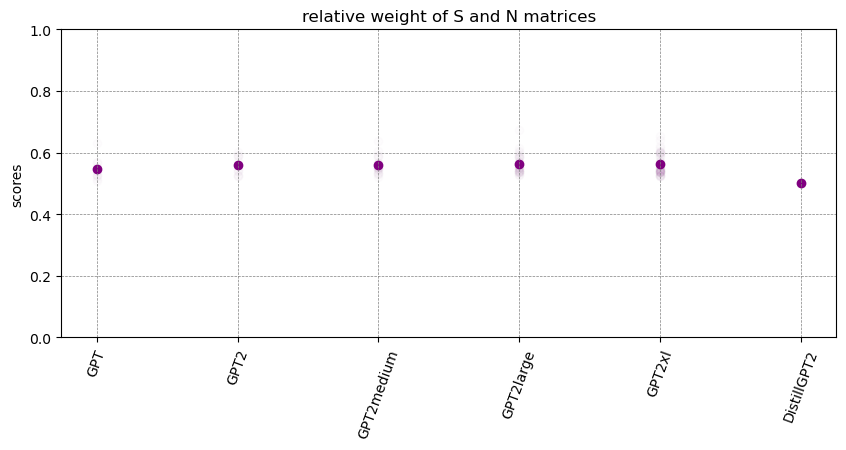

In [6]:
import matplotlib.pyplot as plt

with open('../../_data/fig_scores/GPT-value-out-full.pkl', 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-2].flatten() for key in list(models.keys())]
NList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()**2),color='purple',alpha=.01)
    plt.scatter(i,(SList[i].flatten()**2).mean(),color='purple')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)